In [1]:
import numpy as np
import deepdish.io as io
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [68]:
yhat = np.load('yhat.npy')
test = io.load('data/test_dict.hdf5')
y = test['y']
w = test['w']
X = test['X']

In [12]:
y_true = np.argmax(y, axis=1)
yhat_top1 = np.argmax(yhat, axis=1)

(0, 90000)

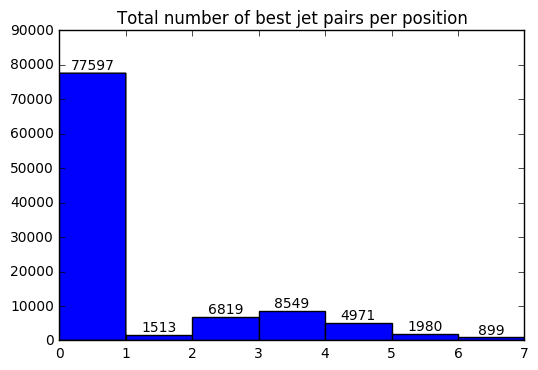

In [56]:
bins = np.linspace(0, max(y_true), max(y_true)+1)
h1 = plt.hist(y_true, bins=bins) #weights=w
plt.title('Total number of best jet pairs per position') # unweighted

for k in range(max(y_true)):
    plt.text((h1[1][k] + h1[1][k+1])/2, 100+h1[0][k],
                '%d' % int(h1[0][k]),
                ha='center', va='bottom')
plt.ylim(0, 90000)

(0, 90000)

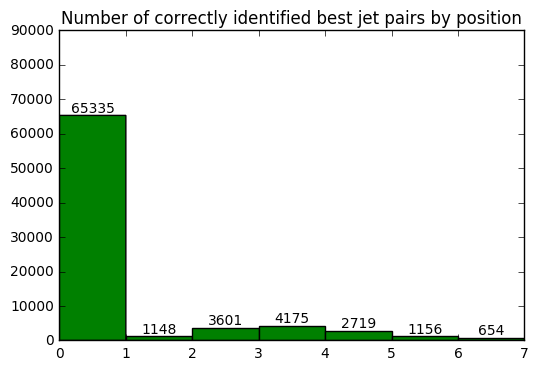

In [54]:
h2 = plt.hist(y_true[yhat_top1 == y_true], bins=bins, color='green')
plt.title('Number of correctly identified best jet pairs by position')
for k in range(max(y_true)):
    plt.text((h2[1][k] + h2[1][k+1])/2, 100+h2[0][k],
                '%d' % int(h2[0][k]),
                ha='center', va='bottom')
plt.ylim(0, 90000)

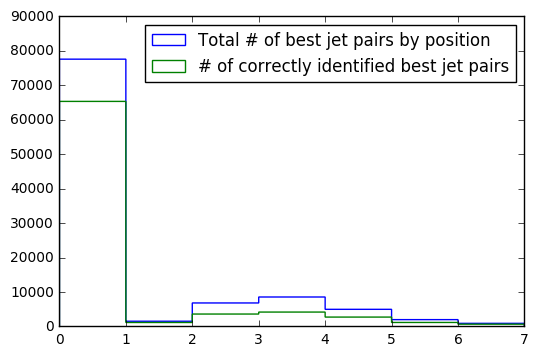

In [59]:
h1 = plt.hist(y_true, bins=bins, histtype='step', color='blue',
              label='Total # of best jet pairs by position')
h2 = plt.hist(y_true[yhat_top1 == y_true], bins=bins, histtype='step', color='green',
              label='# of correctly identified best jet pairs')
_ = plt.ylim(0, 90000)
_ = plt.legend()
# -- this is the same as above, but with the 2 histograms on the same plot for comparison

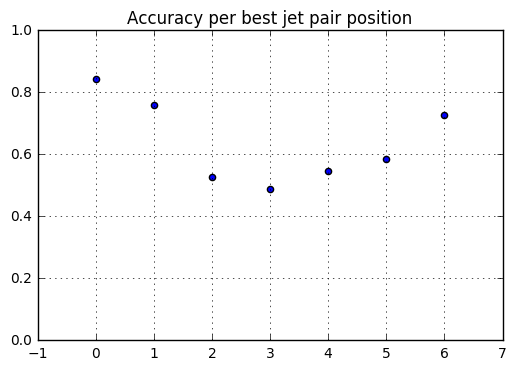

In [66]:
_ = plt.scatter(h1[1][:-1], h2[0] / h1[0])
_ = plt.ylim(0, 1)
plt.grid('on')
plt.title('Accuracy per best jet pair position')

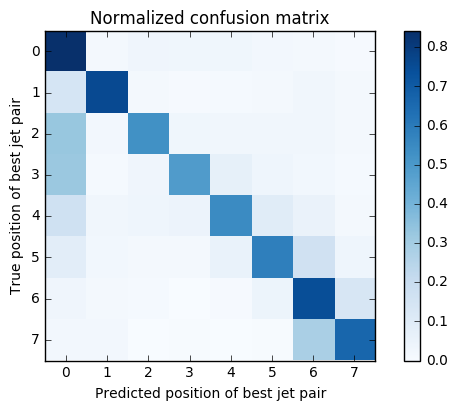

In [67]:
from sklearn.metrics import confusion_matrix
def _plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(np.unique(y_true)))
    plt.xticks(tick_marks, np.unique(y_true))
    plt.yticks(tick_marks, np.unique(y_true))
    plt.tight_layout()
    plt.ylabel('True position of best jet pair')
    plt.xlabel('Predicted position of best jet pair')

cm = confusion_matrix(y_true, yhat_top1)
# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
_plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

In [74]:
import cPickle as pickle
d = pickle.load(open(
    '../James/bbyy_jet_classifier/data/eventLevel_Oct15/SM_bkg_photon_jet.root---events_1tag---0.7---test.pkl', 'rb')
)

In [79]:
np.where(np.array(d['classification_variables']) == 'm_jb')

(array([7]),)

In [135]:
d['classification_variables']

['abs_eta_j',
 'abs_eta_jb',
 'Delta_eta_jb',
 'Delta_phi_jb',
 'idx_by_mH',
 'idx_by_pT',
 'idx_by_pT_jb',
 'm_jb',
 'passes_WP77',
 'passes_WP85',
 'pT_j',
 'pT_jb']

In [83]:
m_jb = X[:, :, 7]

In [166]:
m_jb_true = np.array(
    [m_jb[ev][y_true[ev]-1] if (y_true[ev]-1 >= 0) else -99 for ev in range(len(y_true))]
)

In [165]:
m_jb_pred = np.array(
    [m_jb[ev][yhat_top1[ev]-1] if (yhat_top1[ev]-1 >= 0) else -99 for ev in range(len(yhat_top1))]
)

In [153]:
y_mHmatch = np.array([
        np.argmin(ev[ev != -999]) if (ev[ev != -999].size != 0) else -1 for ev in X[:, :, 4]
])
m_jb_mHmatch = np.array(
    [m_jb[ev][y_mHmatch[ev]] if (y_mHmatch[ev] >= 0) else -99 for ev in range(len(y_mHmatch))]
)

In [152]:
y_pThigh = np.array([
        np.argmin(ev[ev != -999]) if (ev[ev != -999].size != 0) else -1 for ev in X[:, :, 5]
])
m_jb_pThigh = np.array(
    [m_jb[ev][y_pThigh[ev]] if (y_pThigh[ev] >= 0) else -99 for ev in range(len(y_pThigh))]
)

In [151]:
y_pTjbhigh = np.array([
        np.argmin(ev[ev != -999]) if (ev[ev != -999].size != 0) else -1 for ev in X[:, :, 6]
])
m_jb_pTjbhigh = np.array(
    [m_jb[ev][y_pTjbhigh[ev]] if (y_pTjbhigh[ev] >= 0) else -99 for ev in range(len(y_pTjbhigh))]
)

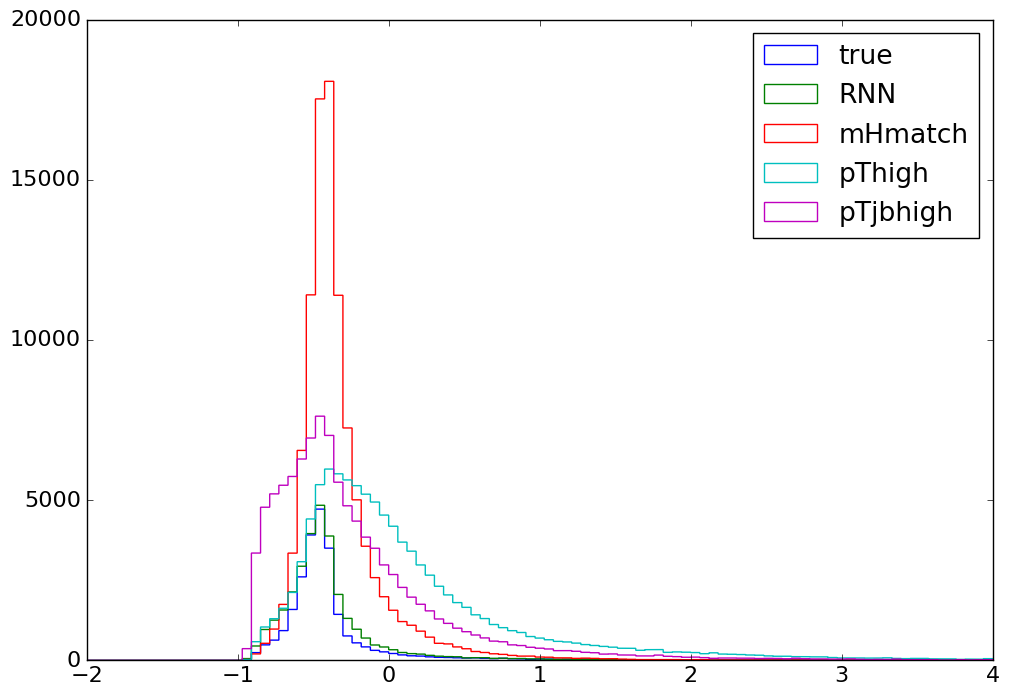

In [164]:
matplotlib.rcParams.update({'font.size': 16})
fig = plt.figure(figsize=(11.69, 8.27), dpi=100)
bins = np.linspace(-2, 4, 100)
_ = plt.hist(m_jb_true, bins=bins, histtype='step', label='true')
_ = plt.hist(m_jb_pred, bins=bins, histtype='step', label='RNN')
_ = plt.hist(m_jb_mHmatch, bins=bins, histtype='step', label='mHmatch')
_ = plt.hist(m_jb_pThigh, bins=bins, histtype='step', label='pThigh')
_ = plt.hist(m_jb_pTjbhigh, bins=bins, histtype='step', label='pTjbhigh')
plt.legend()

The distributions for 'true' and 'RNN' have lower area than the other three because these strategies are allowed to tell us that there was no correct jet pair in an event, hence automatically removing those events. On the other hand, the other three strategies are forced to pick a correct jet pair in any case, even when there isn't a good one.

To make the comparison fairer, we can condition on the existance of a correct jet pair, but the strategy would have never known this and would have still made a choice.

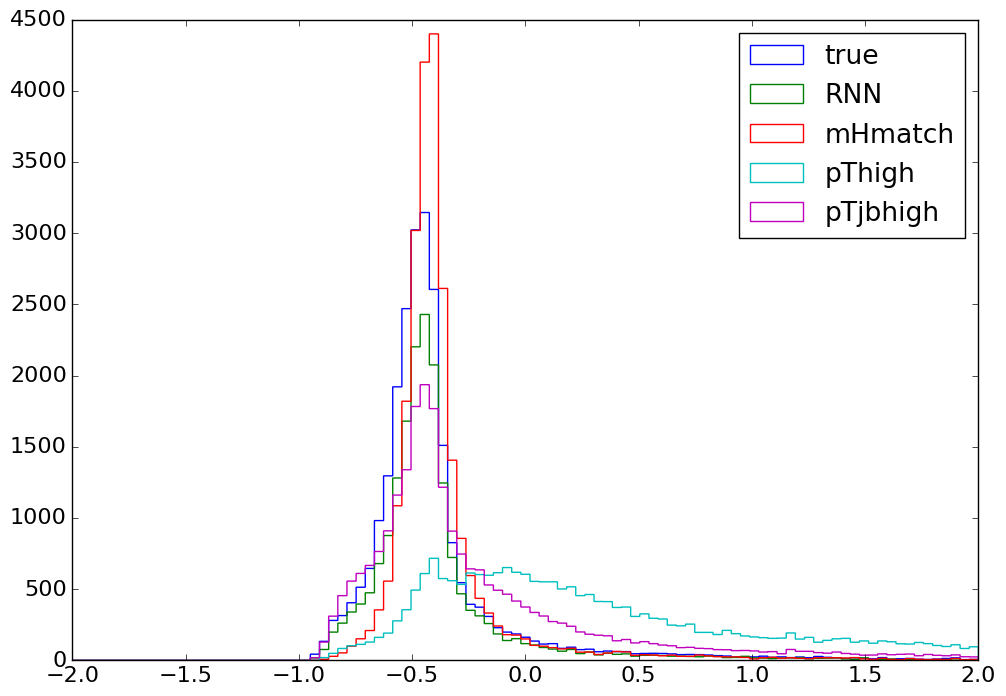

In [168]:
matplotlib.rcParams.update({'font.size': 16})
fig = plt.figure(figsize=(11.69, 8.27), dpi=100)
bins = np.linspace(-2, 2, 100)
_ = plt.hist(m_jb_true[y_true != 0], bins=bins, histtype='step', label='true')
_ = plt.hist(m_jb_pred[y_true != 0], bins=bins, histtype='step', label='RNN')
_ = plt.hist(m_jb_mHmatch[y_true != 0], bins=bins, histtype='step', label='mHmatch')
_ = plt.hist(m_jb_pThigh[y_true != 0], bins=bins, histtype='step', label='pThigh')
_ = plt.hist(m_jb_pTjbhigh[y_true != 0], bins=bins, histtype='step', label='pTjbhigh')
plt.legend()

In [148]:
len(np.array(m_jb_pThigh) != -99), len(np.array(m_jb_mHmatch) != -99)

(102328, 102328)

In [158]:
sum(m_jb_pThigh == -99)

117

In [159]:
sum(m_jb_pTjbhigh == -99)

117

In [161]:
sum(m_jb_mHmatch == -99)

117

In [140]:
# need to save out the standard scaler to shift m_jb back
# need to save out the name of the original file to be able to distinguish signal and background